In [1]:
#Question 01

import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import cv2 as cv
import math
import random


# np . random . seed ( 0)
num_matches = 100
half_n = num_matches//2
r = 10
st_deviation = r/16
t = np.random.uniform (0 , 2*np.pi , half_n )
num_matches = st_deviation*np.random.randn(half_n)
x , y = ( r + num_matches)*np.cos(t) , ( r + num_matches)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n , 1) , y.reshape(half_n , 1)))
m, b = -1, 2
x = np . linspace(-12, 12 , half_n)
y = m*x + b + st_deviation*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n , 1 ), y.reshape( half_n , 1 )))
X = np.vstack((X_circ , X_line))

Text(0.5, 1.0, 'Original Data Points')

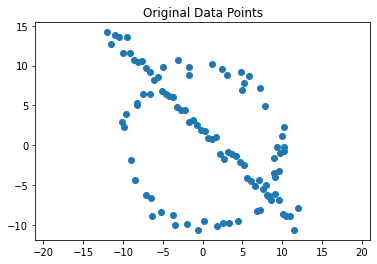

In [2]:
x_coordinates = X[:, 0]
y_coordinates = X[:, 1]
fig, ax = plt.subplots(1, 1)
ax.axis('equal')
ax.scatter(x_coordinates, y_coordinates)
ax.set_title('Original Data Points')

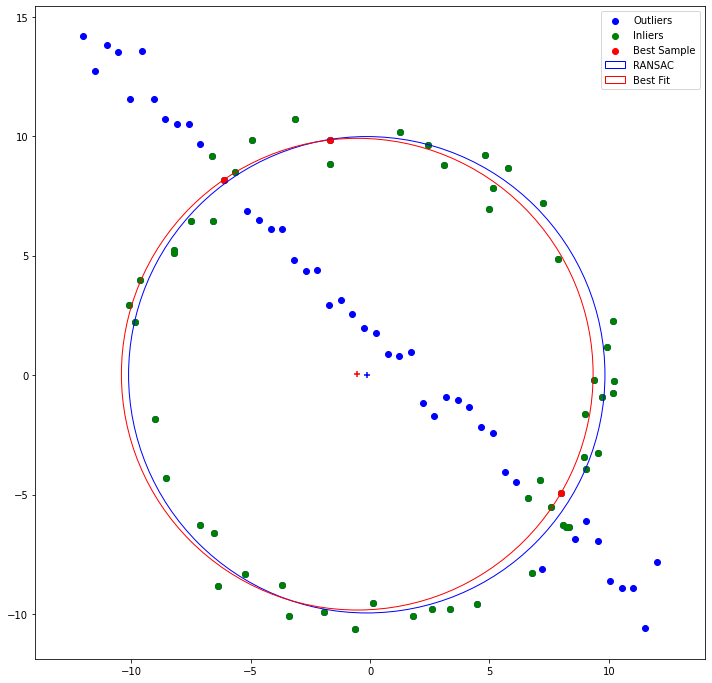

In [3]:

def evaluate_circle(x1, y1 ,x2, y2, x3, y3):
    x12 = x1 - x2
    x13 = x1 - x3
 
    x31 = x3 - x1
    x21 = x2 - x1

    y12 = y1 - y2
    y13 = y1 - y3

    y31 = y3 - y1
    y21 = y2 - y1

    sq_diff_x13 = x1**2 - x3**2
    sq_diff_y13 = y1**2 - y3**2
    sq_diff_x21 = x2**2 - x1**2
    sq_diff_y21 = y2**2 - y1**2

 
    h = -0.5* (sq_diff_x13*x12 + sq_diff_y13*x12 + sq_diff_x21*x13 + sq_diff_y21*x13)/(y31*x12 - y21*x13)
    k = -0.5* (sq_diff_x13*y12 + sq_diff_y13*y12 + sq_diff_x21*y13 + sq_diff_y21*y13)/(x31*y12 - x21*y13)
    c = -x1**2 - y1**2 + 2*k*x1 + 2*h*y1

    r = math.sqrt(h**2 + k**2 - c)

    return k, h, r


def calculate_error(point_arr, center_x, center_y, radius):
    error = np.sum(np.abs(np.sqrt( (point_arr[:, 0] - center_x)**2 + (point_arr[:, 1] - center_y)**2) - radius))
    return error
    

def RANSAC_circle(thresh_distant, max_iterations, points ):
       
    iterations = 0
    max_inlier = 0

    #must be replaced by max_iterations 
    while iterations < max_iterations:
        iterations += 1

        #print(iterations)
        point_index = random.sample(range(0, len(points)), 3)

        x1, y1 = points[point_index[0]]
        x2, y2 = points[point_index[1]]
        x3, y3 = points[point_index[2]]

        center_x, center_y, radius = evaluate_circle(x1, y1, x2, y2, x3, y3)

        min_r = max(radius-thresh_distant, 0)
        max_r = radius + thresh_distant

        num_inlinear_points = 0
        inlinear_arr = []

        for i, point in enumerate(points):
            if min_r < math.sqrt((point[0]-center_x)**2 + (point[1]-center_y)**2) < max_r: 
                inlinear_arr.append(point)
                num_inlinear_points += 1

        inlinear_arr = np.array(inlinear_arr)

        inlier_count = inlinear_arr.shape[0]

        if (inlier_count > max_inlier):
            max_inlier = inlier_count
            
            #error = calculate_error(inlinear_arr, center_x, center_y, radius)
            best_approximation = inlinear_arr
            best_sample = point_index


    P = np.concatenate((best_approximation, np.ones((best_approximation.shape[0], 1))), axis=1) 
    Q = best_approximation[:,[0]]**2 + best_approximation[:, [1]]**2
    B = np.linalg.pinv(P.T @ P) @ P.T @ Q
    a0, b0, c = B.flatten(); a0, b0 = a0/2, b0/2 
    r0 = np.sqrt(a0**2 + b0**2 + c)

    return a0, b0, r0, best_sample, best_approximation

a, b, r, best_sample, best_approximation = RANSAC_circle(st_deviation*1.96, 1000, X)   

x_coordinates = X[:, 0]
y_coordinates = X[:, 1]
fig, ax = plt.subplots(1, 1, figsize = (12, 12))
ax.axis('equal')
ax.scatter(x_coordinates, y_coordinates, c='b', marker='o', label="Outliers")

ax.scatter(best_approximation[:, 0], best_approximation[:, 1], c='g', marker='o', label="Inliers")
ax.scatter(X[best_sample][:, 0], X[best_sample][:, 1], c='r', marker='o', label= "Best Sample")
circle_best_fit = plt.Circle((a, b), radius=r, color='b', fc='y', fill=False, label='RANSAC')
ax.scatter(a, b, c='b', marker='+')


sample_center_x, sample_center_y, sample_radius = evaluate_circle(X[best_sample[0]][0], X[best_sample[0]][1], X[best_sample[1]][0], X[best_sample[1]][1], X[best_sample[2]][0], X[best_sample[2]][1])
ax.scatter(sample_center_x, sample_center_y, c='r', marker='+')
circle_sample = plt.Circle((sample_center_x, sample_center_y), radius=sample_radius, color='r', fc='y', fill=False, label='Best Fit')
plt.gca().add_patch(circle_best_fit)
plt.gca().add_patch(circle_sample)


ax.legend()
plt.show()
    

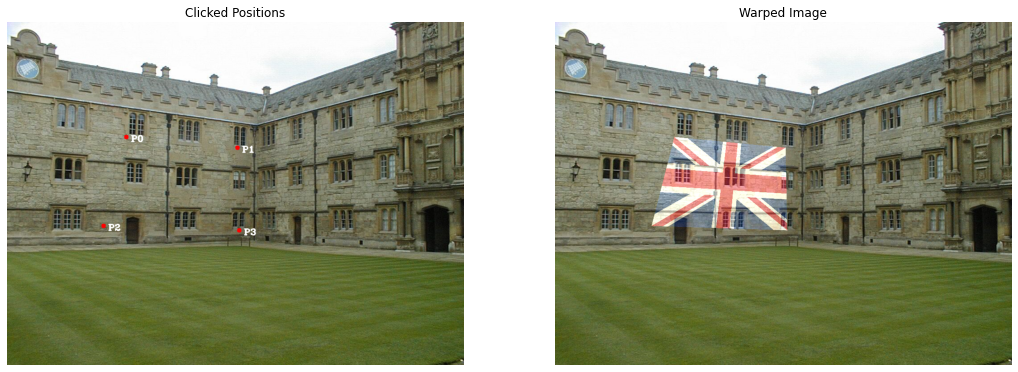

In [4]:
#Question 02

def click_event(event, x, y, flags, params):
    global click_count
    global positions
    if event == cv.EVENT_LBUTTONDOWN and click_count < 4:
        positions = np.vstack((positions, [x, y]))
        font = cv.FONT_HERSHEY_COMPLEX_SMALL 
        cv.circle(img,(x,y), 5,(0,0,255),-1)
        cv.putText(img, "P{}".format(click_count), (x+10,y+10), font, 1, (255, 255, 255), 2)
        cv.imshow('image', img)
        click_count += 1

def calculate_homography(source, destination):
    matches = source.shape[0]
    A = np.empty((2*matches, 9)) 

    for i in range(matches):
        A[2*i]   =   [source[i][0],  source[i][1], 1, 0, 0, 0, -destination[i][0] * source[i][0], -destination[i][0] * source[i][1], -destination[i][0]]
        A[2*i + 1] = [0, 0, 0, source[i][0], source[i][1], 1, -destination[i][1] * source[i][0], -destination[i][1] * source[i][1], -destination[i][1]]
    
    W, V = np.linalg.eig(A.T @ A) 
    homography = V[:, np.argmin(W)] 
    return homography.reshape((3, 3)) 

positions = np.empty((0,2))
click_count = 0
  

img = cv.imread('images/warp_images/002.jpg') 
img_1 = img.copy()

cv.imshow('image', img); cv.setMouseCallback('image', click_event); cv.waitKey(0); cv.destroyAllWindows()
uk_flag = cv.imread('images/warp_images/uk.png') 
shape = uk_flag.shape
flag_pos = np.array([[0, 0],[shape[1]-1, 0],[0, shape[0]-1],[shape[1]-1, shape[0]-1]])
homography = calculate_homography(flag_pos, positions) 
projected = cv.warpPerspective(uk_flag, homography, (img.shape[1], img.shape[0])) 
output = cv.addWeighted(img_1, 1, projected, 0.5, 0) 

fig, ax = plt.subplots(1, 2, figsize=(18, 10))
ax[0].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax[0].set_title("Clicked Positions")
ax[0].axis('off')
ax[1].imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
ax[1].set_title("Warped Image")
ax[1].axis('off')
plt.show()

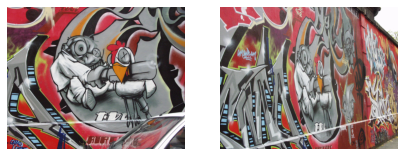

In [5]:
#Question 03

img1 = cv.imread("images/graf/img1.ppm")
img2 = cv.imread("images/graf/img5.ppm")

assert img1 is not None
assert img2 is not None

grey1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
grey2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 2, figsize = (7, 12))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[1].axis('off')

plt.show()



Text(0.5, 1.0, 'Stitched Image')

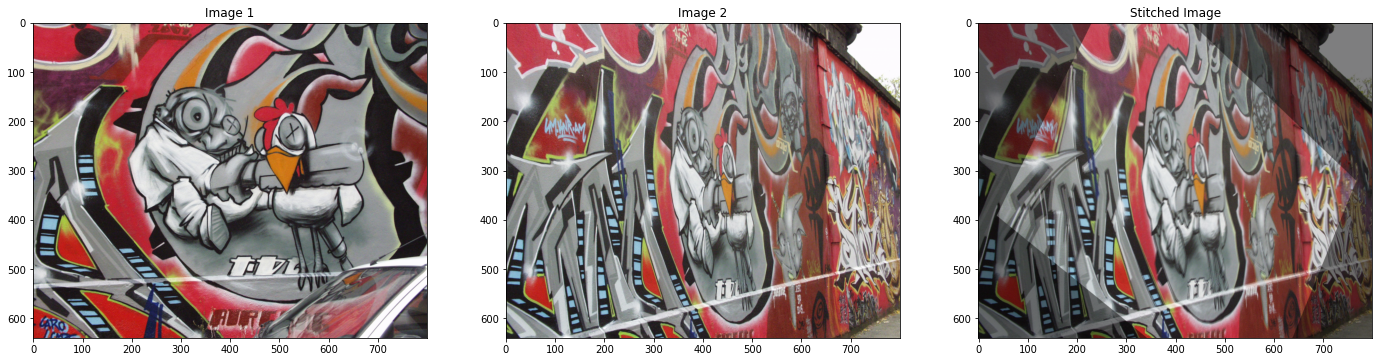

In [12]:
def calc_homography_RANSAC(source, destination, iterations, threshold):
    best_inlier_arr = []
    num_matches = len(source)

    for i in range(iterations):
        #random_index = np.random.randint(num_matches, size=4)

        random_index = random.sample(range(0, num_matches), 4)
        random_source = source[random_index]
        random_destination = destination[random_index]
        H = calculate_homography(random_source, random_destination)
        inlier_arr = []

        for j in range(num_matches):
            estimation = H @ np.hstack((source[j], 1));
            estimation = (1/estimation[2])*estimation[:2]
            error = np.linalg.norm(estimation - destination[j]) 
            if error < threshold:
                 inlier_arr.append(j)
        if len(inlier_arr) > len(best_inlier_arr):
            best_inlier_arr = inlier_arr; 
        if (len(best_inlier_arr) > num_matches*0.5):
            break 
    return best_inlier_arr, H

sift = cv.SIFT_create()

img1 = cv.imread('images/graf/img1.ppm')
assert img1 is not None
img2 = cv.imread('images/graf/img4.ppm')
assert img2 is not None
img3 = cv.imread('images/graf/img5.ppm')

grey1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
grey2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
grey3 = cv.cvtColor(img3, cv.COLOR_BGR2GRAY)

keypoints_img1, descriptors_img1 = sift.detectAndCompute(grey1,None)
keypoints_img2, descriptors_img2 = sift.detectAndCompute(grey2,None)
keypoints_img3, descriptors_img3 = sift.detectAndCompute(grey3,None)

sift = cv.xfeatures2d.SIFT_create()
keypoint_1, descriptor_1 = sift.detectAndCompute(grey1, None)
keypoint_2, descriptor_2 = sift.detectAndCompute(grey2, None)
keypoint_3, descriptor_3 = sift.detectAndCompute(grey3, None)

# FLANN parameters

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptor_1,descriptor_2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.65*n.distance:
        good.append(m)

src_pts = np.float32([ keypoint_1[m.queryIdx].pt for m in good ])
dst_pts = np.float32([ keypoint_2[m.trainIdx].pt for m in good ])
inl, H1 = calc_homography_RANSAC(src_pts, dst_pts, 100, 10)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptor_2,descriptor_3,k=2)

good = []
for m,n in matches:
    if m.distance < 0.65*n.distance:
        good.append(m)

src_pts = np.float32([ keypoint_2[m.queryIdx].pt for m in good ])
dst_pts = np.float32([ keypoint_3[m.trainIdx].pt for m in good ])
inl, H2 = calc_homography_RANSAC(src_pts, dst_pts, 100, 10)
    
# img3 = cv.drawMatches(img1,keypoint_1,img2,keypoint_2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# cv.imshow('image', img3)
# cv.waitKey(0)
# cv.destroyAllWindows()



img4 = cv.warpPerspective(img1, H1, (img2.shape[1], img2.shape[0]))
img5 = cv.warpPerspective(img2, H2, (img3.shape[1], img3.shape[0]))
fig, ax= plt.subplots(1, 3, figsize=(24,10))
ax[0].set_title("Image 1")
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[1].set_title("Image 2")
ax[1].imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
ax[2].imshow(cv.cvtColor(cv.addWeighted(img3,0.5,img5,0.5,0), cv.COLOR_BGR2RGB))
ax[2].set_title("Stitched Image")